In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import time
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

SEED=8
np.random.seed(SEED)
torch.manual_seed(SEED)

%cd /content/drive/MyDrive/Denoising Flower Images AutoEncoderPytorch

/content/drive/MyDrive/Denoising Flower Images AutoEncoderPytorch


In [3]:
def add_noise(img, noise_type="gaussian"):
  row,col,channel=128,128,3
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=0.5
    sigma=np.sqrt(var)
    noise=sigma*np.random.randn(row,col,channel)+mean
    img+=noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col,channel)
    img+=noise*img
    return img

In [4]:
data=os.listdir('/content/drive/MyDrive/Denoising Flower Images AutoEncoderPytorch/FlowerSet')
train_paths, test_paths = train_test_split(data, test_size=0.25, random_state=SEED)

In [5]:
def get_data(paths):
    data=[]
    for e in paths:
        img_dir=os.path.join('/content/drive/MyDrive/Denoising Flower Images AutoEncoderPytorch/FlowerSet', e)
        img=cv2.imread(img_dir)
        img=cv2.resize(img, (128,128))
        data.append(img)
    return data

def get_noisy_data(data):
    i=0
    noisy_data=[]
    for img in data:
        if i<=len(data)//2:
            noisy_img=add_noise(img, 'gaussian')
        else:
            noisy_img=add_noise(img, 'speckle')
        i+=1
        noisy_data.append(noisy_img)
    return noisy_data

In [6]:
y_train = get_data(train_paths)
y_test = get_data(test_paths)

X_train = get_noisy_data(y_train)
X_test = get_noisy_data(y_test)

In [7]:
class ImageSet(Dataset):
    def __init__(self, X, y, transforms):
        self.dirty=X
        self.clean=y
        self.transform=transforms

    def __len__(self):
        return len(self.clean)

    def __getitem__(self,i):
        X=np.asarray(self.dirty[i][:]).astype(np.uint8).reshape((128, 128, 3))
        y=np.asarray(self.clean[i][:]).astype(np.uint8).reshape((128, 128, 3))

        if self.transform!=None:
            X=self.transform(X).type(torch.float32)
            y=self.transform(y).type(torch.float32)

        return (X,y)

In [8]:
# Hyperparameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 4

transformations=transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

train_data = ImageSet(X_train, y_train, transformations)
test_data = ImageSet(X_test, y_test, transformations)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device
    
device = get_device()
print(device)

cuda


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.enco1=nn.Conv2d(3, 128, kernel_size=2, padding=1)
        self.enco2=nn.Conv2d(128, 64, kernel_size=2, padding=1)
        self.enco3=nn.Conv2d(64, 32, kernel_size=2, padding=0)

        self.deco1=nn.ConvTranspose2d(32, 32, kernel_size=2, stride=1)
        self.deco2=nn.ConvTranspose2d(32, 64, kernel_size=2, stride=1)
        self.deco3=nn.ConvTranspose2d(64, 128, kernel_size=2, stride=1)

        self.out=nn.Conv2d(128, 3, kernel_size=2, padding=0)

        self.bn1=nn.BatchNorm2d(128)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(32)

        self.pool=nn.MaxPool2d(kernel_size=(2,2), stride=(1,1))

    def forward(self,x):
        x=self.pool(self.bn1(F.relu(self.enco1(x))))
        x=self.pool(self.bn2(F.relu(self.enco2(x))))
        x=self.pool(self.bn3(F.relu(self.enco3(x))))

        x=self.bn3(F.relu(self.deco1(x)))
        x=self.bn2(F.relu(self.deco2(x)))
        x=self.bn1(F.relu(self.deco3(x)))

        x=torch.sigmoid(self.out(x))

        return x

In [11]:
model = AutoEncoder()
model=model.to(device)

print(model)

AutoEncoder(
  (enco1): Conv2d(3, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (enco2): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (enco3): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
  (deco1): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (deco2): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (deco3): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (out): Conv2d(128, 3, kernel_size=(2, 2), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
)


In [12]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
torch.cuda.empty_cache()

In [14]:
train_loss = []
elapsed_time=0.0
for epoch in range(NUM_EPOCHS):
    epoch_start=time.time()
    running_loss = 0.0
    for dirty,clean in train_loader:
        x = dirty.to(device)
        y = clean.to(device)
        optimizer.zero_grad()
        z = model(x)

        loss = criterion(z,y)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    epoch_end=time.time()

    epoch_elapsed_time=(epoch_end-epoch_start)
    elapsed_time+=epoch_elapsed_time
    if epoch%10==0:
        print('Epoch {:g}/{:g} : Train Loss : {:0.4f} (Elapsed Time: {:0.2f}sec)'.format(epoch+1, NUM_EPOCHS, loss, epoch_elapsed_time))

print('\nTotal Elapsed Time : {:g}min {:.0f}sec'.format(elapsed_time//60, elapsed_time%60))

Epoch 1/100 : Train Loss : 0.0353 (Elapsed Time: 11.66sec)
Epoch 11/100 : Train Loss : 0.0200 (Elapsed Time: 11.57sec)
Epoch 21/100 : Train Loss : 0.0169 (Elapsed Time: 11.57sec)
Epoch 31/100 : Train Loss : 0.0160 (Elapsed Time: 11.54sec)
Epoch 41/100 : Train Loss : 0.0152 (Elapsed Time: 11.55sec)
Epoch 51/100 : Train Loss : 0.0147 (Elapsed Time: 11.56sec)
Epoch 61/100 : Train Loss : 0.0145 (Elapsed Time: 11.54sec)
Epoch 71/100 : Train Loss : 0.0143 (Elapsed Time: 11.53sec)
Epoch 81/100 : Train Loss : 0.0142 (Elapsed Time: 11.56sec)
Epoch 91/100 : Train Loss : 0.0134 (Elapsed Time: 11.56sec)

Total Elapsed Time : 19min 16sec


In [15]:
def save_model(model, path):
    torch.save(model, path)
    print('Done! ==> Model is saved on GPU.')

def load_model(path):
    device = torch.device("cuda")
    model = torch.load(path)
    model.to(device)
    model.eval()
    print('Done! ==> Model is loaded on GPU.')
    return model

In [16]:
model_path='/content/FlowerDenoisingModel_model.pth'
save_model(model, model_path)

Done! ==> Model is saved on GPU.


In [17]:
test_loss=[]
with torch.no_grad():
    for epoch in range(NUM_EPOCHS):
        epoch_start=time.time()
        running_loss=0.0
        for dirty, clean in test_loader:
            x = dirty.to(device)
            y = clean.to(device)
            z=model(x)

            loss=criterion(z,y)
            running_loss+=loss.item()
        epoch_loss=running_loss/len(test_loader)
        test_loss.append(epoch_loss)
        epoch_end=time.time()

        epoch_elapsed_time=(epoch_end-epoch_start)
        elapsed_time+=epoch_elapsed_time
        if epoch%10==0:
            print('Epoch {:g}/{:g} : Test Loss : {:0.4f} (Elapsed Time: {:0.2f}sec)'.format(epoch+1, NUM_EPOCHS, loss, epoch_elapsed_time))


Epoch 1/100 : Test Loss : 0.0141 (Elapsed Time: 1.60sec)
Epoch 10/100 : Test Loss : 0.0156 (Elapsed Time: 1.59sec)
Epoch 19/100 : Test Loss : 0.0045 (Elapsed Time: 1.59sec)
Epoch 28/100 : Test Loss : 0.0064 (Elapsed Time: 1.60sec)
Epoch 37/100 : Test Loss : 0.0142 (Elapsed Time: 1.60sec)
Epoch 46/100 : Test Loss : 0.0076 (Elapsed Time: 1.59sec)
Epoch 55/100 : Test Loss : 0.0204 (Elapsed Time: 1.60sec)
Epoch 64/100 : Test Loss : 0.0302 (Elapsed Time: 1.60sec)
Epoch 73/100 : Test Loss : 0.0153 (Elapsed Time: 1.59sec)
Epoch 82/100 : Test Loss : 0.0064 (Elapsed Time: 1.59sec)
Epoch 91/100 : Test Loss : 0.0100 (Elapsed Time: 1.61sec)
Epoch 100/100 : Test Loss : 0.0057 (Elapsed Time: 1.60sec)


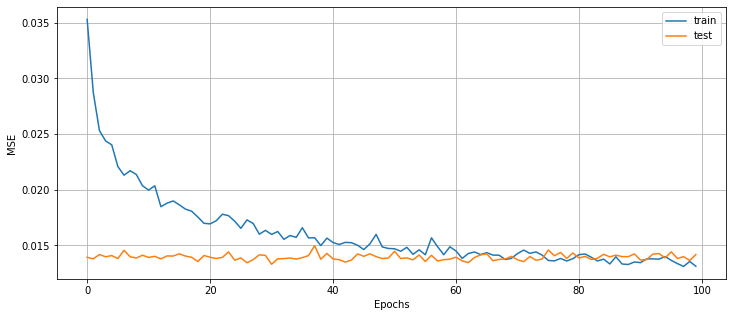

In [18]:
plt.figure(figsize=(12,5))
plt.plot(range(NUM_EPOCHS), train_loss, label='train')
plt.plot(range(NUM_EPOCHS), test_loss, label='test')
plt.grid(True);
plt.legend();
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [19]:
dirtys, cleans, outputs = [], [], []
with torch.no_grad():
    for dirty, clean in test_loader:
        x = dirty.to(device)
        y = clean.to(device)
        z=model(x)

        dirtys.append(x.permute(0,2,3,1).detach().cpu().numpy())    
        cleans.append(y.permute(0,2,3,1).detach().cpu().numpy())
        outputs.append(z.permute(0,2,3,1).detach().cpu().numpy())

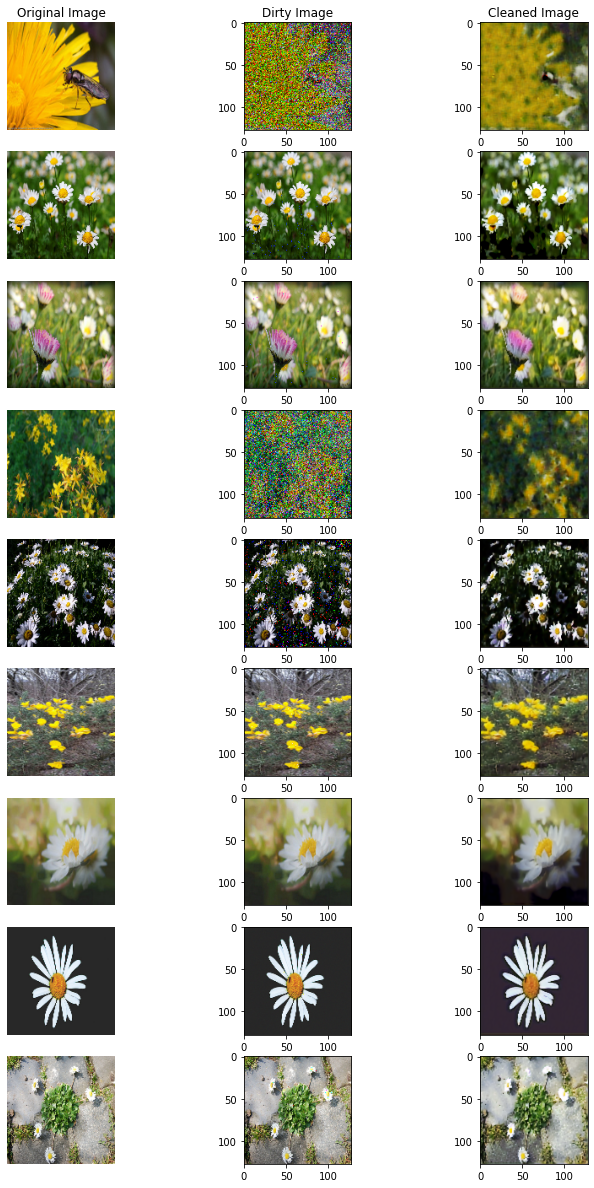

In [25]:
f,axes= plt.subplots(9,3,figsize=(12,21))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

for idx in range(9):
    dirty=cv2.cvtColor(dirtys[idx][0],cv2.COLOR_RGB2BGRA)
    clean=cv2.cvtColor(cleans[idx][0],cv2.COLOR_RGB2BGRA)
    denoised=cv2.cvtColor(outputs[idx][0],cv2.COLOR_RGB2BGRA)
    axes[idx,0].imshow(clean)
    axes[idx,0].axis(False);
    axes[idx,1].imshow(dirty)
    axes[idx,0].axis(False);
    axes[idx,2].imshow(denoised)
    axes[idx,0].axis(False);